In [1]:
import torch
import os
import os.path as osp
from sklearn.metrics import precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy import stats

# AUPP Score

In [2]:
files = [osp.join(osp.abspath("result_save"), i, "predict and label.pt") for i in os.listdir("result_save")]
print(files[0])
print(len(files))

/mnt/workspace/HIGH-PPI/result_save/high_training_seed_27/predict and label.pt
27


In [3]:
import torch.nn as nn
from utils import Metrictor_PPI
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = nn.Sigmoid()

In [4]:
high_files = list(filter(lambda x: x.find('high') >= 0, files))  # HIGH-PPI
pipr_files = list(filter(lambda x: x.find('pipr') >= 0, files))  # PIPR
gnn_files = list(filter(lambda x: x.find('gnn') >= 0, files))  # GNN-PPI

In [5]:
def compute_aupr(files):
    exps = [torch.load(file) for file in files]
    auprs = []
    
    for exp in exps:
        pre_result = (m(exp['predict']) > 0.5).type(torch.FloatTensor).cpu().data
        proba = exp['predict'].cpu().data
        label = exp['label'].cpu().data
        metrics = Metrictor_PPI(pre_result, label, proba)
        metrics.show_result()
        auprs.append(metrics.Aupr)
    mean_aupr = np.mean(auprs, axis=0)
    
    return np.array(auprs), mean_aupr

In [7]:
high_auprs, mean_high_aupr = compute_aupr(high_files)
gnn_auprs, mean_gnn_aupr = compute_aupr(gnn_files)
pipr_auprs, mean_pipr_aupr = compute_aupr(pipr_files)
print("HIGH-PPI mean aupr score: ", mean_high_aupr)
print("GNN-PPI mean aupr score: ", mean_gnn_aupr)
print("PIPR mean aupr score: ", mean_pipr_aupr)

HIGH-PPI mean aupr score:  [0.92005986 0.91285572 0.85566728 0.88941135 0.82940408 0.92563497
 0.53125183]
GNN-PPI mean aupr score:  [0.65029147 0.69683554 0.48895424 0.69571289 0.50344359 0.72710208
 0.31488084]
PIPR mean aupr score:  [0.9127081  0.90756668 0.85730412 0.88644206 0.86148668 0.90698481
 0.51766571]


In [11]:
aupr_dict = {'high': high_auprs, 'pipr': pipr_auprs, 'gnn': gnn_auprs}
print(len(aupr_dict.keys()))

3


In [27]:
class_map = {'reaction': 0, 'binding': 1, 'ptmod': 2, 'activation': 3, 'inhibition': 4, 'catalysis': 5,
                     'expression': 6}
color_map = {'high': '#f08080', 'pipr': '#ffa500', 'gnn': '#1e90ff'}
class_titles = ['Reaction(55.03%)', 'Binding(60.69%)', 'Ptmod(7.33%)', 'NAN', 'Inhibition(4.11%)', 'Catalysis(45.64%)', 'NAN']

def draw_class_aupr(aupr_dict, class_name, save_folder=None, x_visble=False, y_visble=False):
    plt.figure(figsize=(4, 6))
    idx = class_map[class_name]  # 这个类型的PPI的索引
    model_names = list(aupr_dict.keys())  # 模型名字
    # class_title = class_titles[idx]
    ys = []
    errors = []
    colors = []
    
    for model_name in model_names:
        auprs = aupr_dict[model_name]  # 拿到这个模型的aupr
        class_aupr = auprs[:, idx]  # 拿到对应类型的aupr分数
        mean_aupr = np.mean(class_aupr)  # 算出均值aupr
        sem_aupr = stats.sem(class_aupr)  # 算出标准误差
        
        ys.append(mean_aupr)
        errors.append(sem_aupr)
        colors.append(color_map[model_name])
    
    # 画柱子
    plt.bar(model_names, ys, yerr=errors, capsize=9, color=colors)
    # plt.title(class_title)
    plt.ylabel('AUPR')
    plt.ylim([0.2, 1.00])  # 设画画的限制
    
    # 画误差点
    for i, model_name in enumerate(model_names):
        auprs = aupr_dict[model_name]  # 拿到这个模型的aupr
        class_aupr = auprs[:, idx]  # 观测值
        xs = [i-0.35 + 0.07*j for j in range(1, len(class_aupr)+1)]  # 位置
        plt.scatter(xs, class_aupr, color='gray')
    
    # 隐藏边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    if not x_visble:
        plt.gca().xaxis.set_visible(False)
    if not y_visble:
        plt.gca().yaxis.set_visible(False)    
    if save_folder is not None:
        plt.savefig(osp.join(save_folder, f'{class_name}.png'))

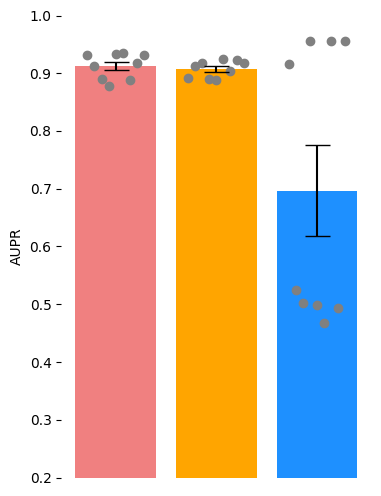

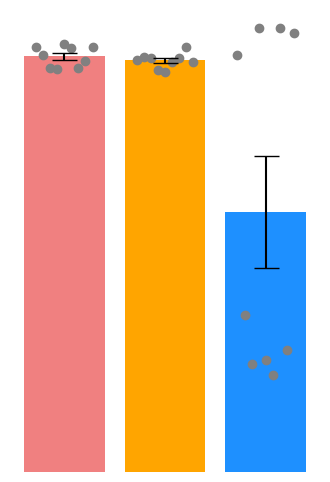

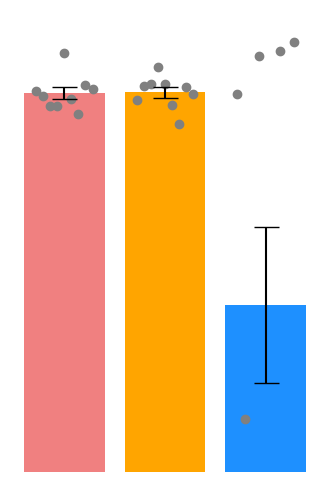

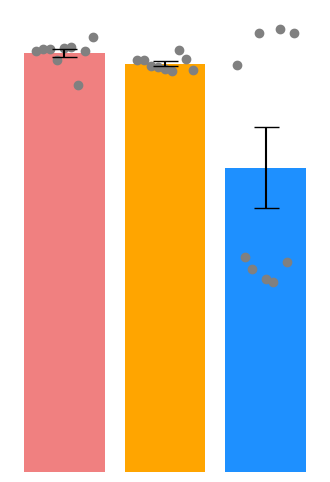

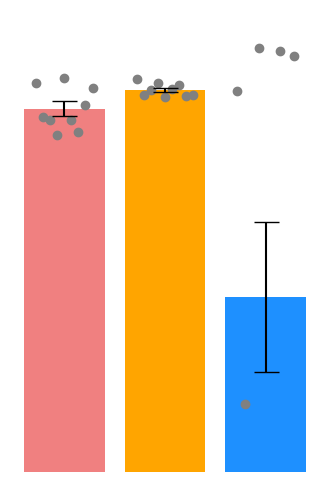

In [28]:
fig_path = './images'
if not osp.exists(fig_path):
    os.mkdir(fig_path)
draw_class_aupr(aupr_dict, 'binding', save_folder=fig_path, y_visble=True)
draw_class_aupr(aupr_dict, 'reaction', save_folder=fig_path)
draw_class_aupr(aupr_dict, 'ptmod', save_folder=fig_path)
draw_class_aupr(aupr_dict, 'catalysis', save_folder=fig_path)
draw_class_aupr(aupr_dict, 'inhibition', save_folder=fig_path)

# OOD

OOD实验中，HIGH-PPI和GNN-PPI都跑了五个case，PIPR只跑了dfs-0.4。也是通过best-F1的方式进行评估

In [50]:
def get_bestF1(logfiles):
    bestF1s = []

    pattern = r"Best valid_f1:\s*([0-9.]+)"
    for log_file in logfiles:
        with open(log_file, 'r') as f:
            content = f.readlines()[-1]
            f1 = re.findall(pattern, content)[0]
            bestF1s.append(float(f1))

    return np.array(bestF1s).reshape(-1, 1)


def get_ood_evaluation(ood_case, model_name='high'):
    # ood_case类似dfs-0.4, bfs-0.3, random-0.35
    case_folder = "OOD_result_save_{}".format(ood_case)
    ood_files = [osp.join(osp.abspath(case_folder), i, "valid_results.txt") for i in os.listdir(case_folder)]
    logfiles = list(filter(lambda x: x.find(model_name) >= 0, ood_files))

    ood_f1s = get_bestF1(logfiles)
    return ood_f1s

In [124]:
# 获取所需数据
high_bfs03 = get_ood_evaluation('bfs-0.3', 'high')
high_dfs03 = get_ood_evaluation('dfs-0.3', 'high')
high_bfs04 = get_ood_evaluation('bfs-0.4', 'high')
high_dfs04 = get_ood_evaluation('dfs-0.4', 'high')
high_r065 = get_ood_evaluation('random-0.35', 'high')

gnn_bfs03 = get_ood_evaluation('bfs-0.3', 'gnn')
gnn_dfs03 = get_ood_evaluation('dfs-0.3', 'gnn')
gnn_bfs04 = get_ood_evaluation('bfs-0.4', 'gnn')
gnn_dfs04 = get_ood_evaluation('dfs-0.4', 'gnn')
gnn_r065 = get_ood_evaluation('random-0.35', 'gnn')


data = np.concatenate([
    gnn_bfs03, high_bfs03,
    gnn_dfs03, high_dfs03,
    gnn_bfs04, high_bfs04,
    gnn_dfs04, high_dfs04,
    gnn_r065, high_r065
], axis=1)
print(data.shape)
# assert data.shape == (10, 5)  # 10个箱图，每个箱有5个数

(5, 10)


In [126]:
high_dfs03

array([[0.68337976],
       [0.68151831],
       [0.69583542],
       [0.67898283],
       [0.66521265]])

In [112]:
pipr_dfs04 = get_ood_evaluation('dfs-0.4', 'pipr')
pipr_value = np.min(pipr_dfs04)
print(pipr_value)

0.49827557886282486


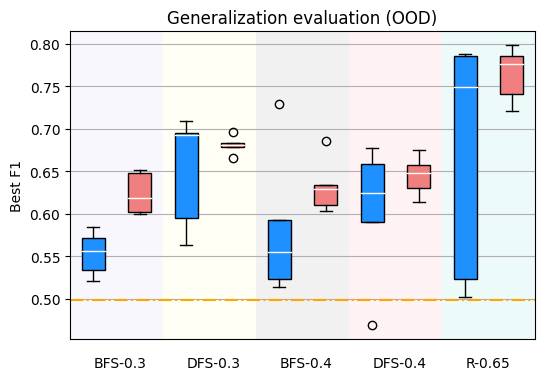

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# 指定每个箱线图的颜色
colors = ['#1e90ff', '#f08080']*5

# 创建并显示带有指定颜色的箱线图
plt.figure(figsize=(6, 4))

medianprops = dict(linestyle='-', color='#fffff5')  # 指定中位数线的颜色和样式
# patch_artist=True，后续才可以设置箱体颜色
bplot = plt.boxplot(data, patch_artist=True, notch=False, medianprops=medianprops)

# 为每个箱体设置颜色
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.axhline(pipr_value, linestyle='-.', color="#ffa500")

# 添加背景色块将不同OOD case区分开来
plt.axvspan(0.5, 2.5, facecolor='#f7f7fd', alpha=1)
plt.axvspan(2.5, 4.5, facecolor='#fffff5', alpha=1)
plt.axvspan(4.5, 6.5, facecolor='#f1f1f1', alpha=1)
plt.axvspan(6.5, 8.5, facecolor='#fff2f4', alpha=1)
plt.axvspan(8.5, 10.5, facecolor='#ecfaf9', alpha=1)
plt.text(1, 0.42, "BFS-0.3")
plt.text(3, 0.42, "DFS-0.3")
plt.text(5, 0.42, "BFS-0.4")
plt.text(7, 0.42, "DFS-0.4")
plt.text(9, 0.42, "R-0.65")

plt.grid(axis='y')  # 显示y轴网格线
plt.gca().xaxis.set_visible(False)  # x轴不显示

plt.ylabel('Best F1')
plt.title('Generalization evaluation (OOD)')  # 标题
plt.savefig('./images/OOD result.png')

plt.show()

# Robustness

每一个ratio都根据5次重复实验，确定出一个上下界。

robustness实验，做了四个ratio，0，0.2，0.4，0.6

其中ratio0即是aupr score，跑了9次重复实验；其他三个ratio跑了5次重复实验

In [75]:
def compute_mean_bestF1(logfiles):
    bestF1s = []

    pattern = r"Best valid_f1:\s*([0-9.]+)"
    for log_file in logfiles:
        with open(log_file, 'r') as f:
            content = f.readlines()[-1]
            f1 = re.findall(pattern, content)[0]
            bestF1s.append(float(f1))
    mean_f1 = np.mean(bestF1s)  # 平均bestF1
    sem_f1 = stats.sem(bestF1s)  # 标准误差
    interval_f1 = stats.t.interval(0.95, len(bestF1s), np.mean(bestF1s), stats.sem(bestF1s))  # 95%置信区间
    return mean_f1, interval_f1


def get_robust_evaluation(ratio, model_name='high'):
    ratio_folder = None
    if ratio != 0:
        ratio_folder = "robust_result_save_perturb-{}".format(float(ratio))
    else:
        ratio_folder = "result_save"
    ratio_files = [osp.join(osp.abspath(ratio_folder), i, "valid_results.txt") for i in os.listdir(ratio_folder)]
    logfiles = list(filter(lambda x: x.find(model_name) >= 0, ratio_files))

    ratio_f1, ratio_interval = compute_mean_bestF1(logfiles)
    return ratio_f1, ratio_interval

In [76]:
high_ratio0_f1, high_ratio0_interval = get_robust_evaluation(0.6, 'high')
print("HIGH-PPI:", high_ratio0_f1, high_ratio0_interval)

HIGH-PPI: 0.6720179761175124 (0.6592528918891469, 0.6847830603458778)


In [77]:
ratios = [0, 0.2, 0.4, 0.6]
high_f1 = []
high_upper = []
high_lower = []
for ratio in ratios:
    f1, interval = get_robust_evaluation(ratio, 'high')
    lower, upper = interval
    high_f1.append(f1)
    high_lower.append(lower)
    high_upper.append(upper)

In [78]:
ratios = [0, 0.2, 0.4, 0.6]
pipr_f1 = []
pipr_upper = []
pipr_lower = []
for ratio in ratios:
    f1, interval = get_robust_evaluation(ratio, 'pipr')
    lower, upper = interval
    pipr_f1.append(f1)
    pipr_lower.append(lower)
    pipr_upper.append(upper)

In [79]:
ratios = [0, 0.2, 0.4, 0.6]
gnn_f1 = []
gnn_upper = []
gnn_lower = []
for ratio in ratios:
    f1, interval = get_robust_evaluation(ratio, 'gnn')
    lower, upper = interval
    gnn_f1.append(f1)
    gnn_lower.append(lower)
    gnn_upper.append(upper)

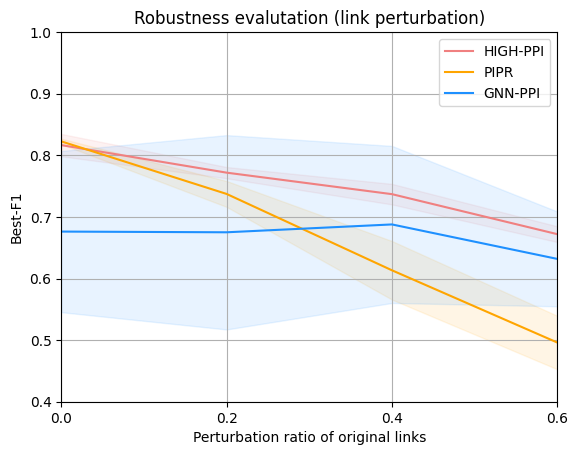

In [131]:
# HIGH-PPI的曲线
plt.plot(ratios, high_f1, color='#f08080', label='HIGH-PPI')
plt.fill_between(ratios, high_lower, high_upper, alpha=0.1, color='#f08080')

# PIPR的曲线
plt.plot(ratios, pipr_f1, color='#ffa500', label='PIPR')
plt.fill_between(ratios, pipr_lower, pipr_upper, alpha=0.1, color='#ffa500')

# GNN-PPI的曲线
plt.plot(ratios, gnn_f1, color='#1e90ff', label='GNN-PPI')
plt.fill_between(ratios, gnn_lower, gnn_upper, alpha=0.1, color='#1e90ff')

plt.title('Robustness evalutation (link perturbation)')
plt.xlabel('Perturbation ratio of original links')
plt.ylabel('Best-F1')
plt.legend()
plt.xlim([0, 0.6])
plt.xticks([0, 0.2, 0.4, 0.6])
plt.ylim([0.4, 1.0])
plt.grid(True)
plt.savefig('./images/robustness.png')